<a href="https://colab.research.google.com/github/aeazraoui/tutorial/blob/master/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/student/W1D3_Tutorial5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/student/W1D3_Tutorial5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/student/W1D3_Tutorial5.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 5: Dynamical Similarity Analysis (DSA)

**Week 1, Day 3: Comparing Artificial And Biological Networks**

**By Neuromatch Academy**

__Content creators:__ Mitchell Ostrow, Alex Murphy

__Content reviewers:__ Xaq Pitkow, Hlib Solodzhuk, Alex Murphy

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk, Patrick Mineault, Alex Murphy


This short notebook expands the toolset of network comparison by taking a look at another important dimension for analysis - time. In particular, it would be beneficial to understand how the systems evolve over time and whether their dynamics are similar. The presented materials are the most similar to the ones introduced in [Tutorial 2](https://neuroai.neuromatch.io/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/student/W1D3_Tutorial2.html) for this day, and one of the projects on [Comparing Networks](https://neuroai.neuromatch.io/projects/project-notebooks/ComparingNetworks.html) is exactly about DSA.

In [1]:
# @title Install and import feedback gadget

!pip install vibecheck rsatoolbox --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W1D5_DSA"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 740.5/740.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00


In [2]:
# @title Helper functions

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def generate_2d_random_process(A, B, T=1000):
    """
    Generates a 2D random process with the equation x(t+1) = A.x(t) + B.noise.

    Args:
        A: 2x2 transition matrix.
        B: 2x2 noise scaling matrix.
        T: Number of time steps.

    Returns:
        A NumPy array of shape (T+1, 2) representing the trajectory.
    """
    # Assuming equilibrium distribution is zero mean and identity covariance for simplicity.
    # You may adjust this according to your actual equilibrium distribution
    x = np.zeros(2)

    trajectory = [x.copy()] # Initialize with x(0)
    for t in range(T):
      noise = np.random.normal(size=2)  # Standard normal noise
      x = np.dot(A, x) + np.dot(B, noise)
      trajectory.append(x.copy())
    return np.array(trajectory)

"""This module computes the Havok DMD model for a given dataset."""
import torch

def embed_signal_torch(data, n_delays, delay_interval=1):
    """
    Create a delay embedding from the provided tensor data.

    Parameters
    ----------
    data : torch.tensor
        The data from which to create the delay embedding. Must be either: (1) a
        2-dimensional array/tensor of shape T x N where T is the number
        of time points and N is the number of observed dimensions
        at each time point, or (2) a 3-dimensional array/tensor of shape
        K x T x N where K is the number of "trials" and T and N are
        as defined above.

    n_delays : int
        Parameter that controls the size of the delay embedding. Explicitly,
        the number of delays to include.

    delay_interval : int
        The number of time steps between each delay in the delay embedding. Defaults
        to 1 time step.
    """
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data)
    device = data.device

    if data.shape[int(data.ndim==3)] - (n_delays - 1)*delay_interval < 1:
        raise ValueError("The number of delays is too large for the number of time points in the data!")

    # initialize the embedding
    if data.ndim == 3:
        embedding = torch.zeros((data.shape[0], data.shape[1] - (n_delays - 1)*delay_interval, data.shape[2]*n_delays)).to(device)
    else:
        embedding = torch.zeros((data.shape[0] - (n_delays - 1)*delay_interval, data.shape[1]*n_delays)).to(device)

    for d in range(n_delays):
        index = (n_delays - 1 - d)*delay_interval
        ddelay = d*delay_interval

        if data.ndim == 3:
            ddata = d*data.shape[2]
            embedding[:,:, ddata: ddata + data.shape[2]] = data[:,index:data.shape[1] - ddelay]
        else:
            ddata = d*data.shape[1]
            embedding[:, ddata:ddata + data.shape[1]] = data[index:data.shape[0] - ddelay]

    return embedding

class DMD:
    """DMD class for computing and predicting with DMD models.
    """
    def __init__(
            self,
            data,
            n_delays,
            delay_interval=1,
            rank=None,
            rank_thresh=None,
            rank_explained_variance=None,
            reduced_rank_reg=False,
            lamb=0,
            device='cpu',
            verbose=False,
            send_to_cpu=False,
            steps_ahead=1
        ):
        """
        Parameters
        ----------
        data : np.ndarray or torch.tensor
            The data to fit the DMD model to. Must be either: (1) a
            2-dimensional array/tensor of shape T x N where T is the number
            of time points and N is the number of observed dimensions
            at each time point, or (2) a 3-dimensional array/tensor of shape
            K x T x N where K is the number of "trials" and T and N are
            as defined above.

        n_delays : int
            Parameter that controls the size of the delay embedding. Explicitly,
            the number of delays to include.

        delay_interval : int
            The number of time steps between each delay in the delay embedding. Defaults
            to 1 time step.

        rank : int
            The rank of V in fitting HAVOK DMD - i.e., the number of columns of V to
            use to fit the DMD model. Defaults to None, in which case all columns of V
            will be used.

        rank_thresh : float
            Parameter that controls the rank of V in fitting HAVOK DMD by dictating a threshold
            of singular values to use. Explicitly, the rank of V will be the number of singular
            values greater than rank_thresh. Defaults to None.

        rank_explained_variance : float
            Parameter that controls the rank of V in fitting HAVOK DMD by indicating the percentage of
            cumulative explained variance that should be explained by the columns of V. Defaults to None.

        reduced_rank_reg : bool
            Determines whether to use reduced rank regression (True) or principal component regression (False)

        lamb : float
            Regularization parameter for ridge regression. Defaults to 0.

        device: string, int, or torch.device
            A string, int or torch.device object to indicate the device to torch.

        verbose: bool
            If True, print statements will be provided about the progress of the fitting procedure.

        send_to_cpu: bool
            If True, will send all tensors in the object back to the cpu after everything is computed.
            This is implemented to prevent gpu memory overload when computing multiple DMDs.

        steps_ahead: int
            The number of time steps ahead to predict. Defaults to 1.
        """

        self.device = device
        self._init_data(data)

        self.n_delays = n_delays
        self.delay_interval = delay_interval
        self.rank = rank
        self.rank_thresh = rank_thresh
        self.rank_explained_variance = rank_explained_variance
        self.reduced_rank_reg = reduced_rank_reg
        self.lamb = lamb
        self.verbose = verbose
        self.send_to_cpu = send_to_cpu
        self.steps_ahead = steps_ahead

        # Hankel matrix
        self.H = None

        # SVD attributes
        self.U = None
        self.S = None
        self.V = None
        self.S_mat = None
        self.S_mat_inv = None

        # DMD attributes
        self.A_v = None
        self.A_havok_dmd = None

    def _init_data(self, data):
        # check if the data is an np.ndarry - if so, convert it to Torch
        if isinstance(data, np.ndarray):
            data = torch.from_numpy(data)
        self.data = data
        # create attributes for the data dimensions
        if self.data.ndim == 3:
            self.ntrials = self.data.shape[0]
            self.window = self.data.shape[1]
            self.n = self.data.shape[2]
        else:
            self.window = self.data.shape[0]
            self.n = self.data.shape[1]
            self.ntrials = 1

    def compute_hankel(
            self,
            data=None,
            n_delays=None,
            delay_interval=None,
        ):
        """
        Computes the Hankel matrix from the provided data.

        Parameters
        ----------
        data : np.ndarray or torch.tensor
            The data to fit the DMD model to. Must be either: (1) a
            2-dimensional array/tensor of shape T x N where T is the number
            of time points and N is the number of observed dimensions
            at each time point, or (2) a 3-dimensional array/tensor of shape
            K x T x N where K is the number of "trials" and T and N are
            as defined above.

        n_delays : int
            Parameter that controls the size of the delay embedding. Explicitly,
            the number of delays to include. Defaults to None - provide only if you want
            to override the value of n_delays from the init.

        delay_interval : int
            The number of time steps between each delay in the delay embedding. Defaults
            to 1 time step. Defaults to None - provide only if you want
            to override the value of n_delays from the init.
        """
        if self.verbose:
            print("Computing Hankel matrix ...")

        # if parameters are provided, overwrite them from the init
        self.data = self.data if data is None else self._init_data(data)
        self.n_delays = self.n_delays if n_delays is None else n_delays
        self.delay_interval = self.delay_interval if delay_interval is None else delay_interval
        self.data = self.data.to(self.device)

        self.H = embed_signal_torch(self.data, self.n_delays, self.delay_interval)

        if self.verbose:
            print("Hankel matrix computed!")

    def compute_svd(self):
        """
        Computes the SVD of the Hankel matrix.
        """

        if self.verbose:
            print("Computing SVD on Hankel matrix ...")
        if self.H.ndim == 3: #flatten across trials for 3d
            H = self.H.reshape(self.H.shape[0] * self.H.shape[1], self.H.shape[2])
        else:
            H = self.H
        # compute the SVD
        U, S, Vh = torch.linalg.svd(H.T, full_matrices=False)

        # update attributes
        V = Vh.T
        self.U = U
        self.S = S
        self.V = V

        # construct the singuar value matrix and its inverse
        # dim = self.n_delays * self.n
        # s = len(S)
        # self.S_mat = torch.zeros(dim, dim,dtype=torch.float32).to(self.device)
        # self.S_mat_inv = torch.zeros(dim, dim,dtype=torch.float32).to(self.device)
        self.S_mat = torch.diag(S).to(self.device)
        self.S_mat_inv= torch.diag(1 / S).to(self.device)

        # compute explained variance
        exp_variance_inds = self.S**2 / ((self.S**2).sum())
        cumulative_explained = torch.cumsum(exp_variance_inds, 0)
        self.cumulative_explained_variance = cumulative_explained

        #make the X and Y components of the regression by staggering the hankel eigen-time delay coordinates by time
        if self.reduced_rank_reg:
            V = self.V
        else:
            V = self.V

        if self.ntrials > 1:
            if V.numel() < self.H.numel():
                raise ValueError("The dimension of the SVD of the Hankel matrix is smaller than the dimension of the Hankel matrix itself. \n \
                                 This is likely due to the number of time points being smaller than the number of dimensions. \n \
                                 Please reduce the number of delays.")

            V = V.reshape(self.H.shape)

            #first reshape back into Hankel shape, separated by trials
            newshape = (self.H.shape[0]*(self.H.shape[1]-self.steps_ahead),self.H.shape[2])
            self.Vt_minus = V[:,:-self.steps_ahead].reshape(newshape)
            self.Vt_plus = V[:,self.steps_ahead:].reshape(newshape)
        else:
            self.Vt_minus = V[:-self.steps_ahead]
            self.Vt_plus = V[self.steps_ahead:]


        if self.verbose:
            print("SVD complete!")

    def recalc_rank(self,rank,rank_thresh,rank_explained_variance):
        '''
        Parameters
        ----------
        rank : int
            The rank of V in fitting HAVOK DMD - i.e., the number of columns of V to
            use to fit the DMD model. Defaults to None, in which case all columns of V
            will be used. Provide only if you want to override the value from the init.

        rank_thresh : float
            Parameter that controls the rank of V in fitting HAVOK DMD by dictating a threshold
            of singular values to use. Explicitly, the rank of V will be the number of singular
            values greater than rank_thresh. Defaults to None - provide only if you want
            to override the value from the init.

        rank_explained_variance : float
            Parameter that controls the rank of V in fitting HAVOK DMD by indicating the percentage of
            cumulative explained variance that should be explained by the columns of V. Defaults to None -
            provide only if you want to overried the value from the init.
            '''
        # if an argument was provided, overwrite the stored rank information
        none_vars = (rank is None) + (rank_thresh is None) + (rank_explained_variance is None)
        if none_vars != 3:
            self.rank = None
            self.rank_thresh = None
            self.rank_explained_variance = None

        self.rank = self.rank if rank is None else rank
        self.rank_thresh = self.rank_thresh if rank_thresh is None else rank_thresh
        self.rank_explained_variance = self.rank_explained_variance if rank_explained_variance is None else rank_explained_variance

        none_vars = (self.rank is None) + (self.rank_thresh is None) + (self.rank_explained_variance is None)
        if none_vars < 2:
            raise ValueError("More than one value was provided between rank, rank_thresh, and rank_explained_variance. Please provide only one of these, and ensure the others are None!")
        elif none_vars == 3:
           self.rank = len(self.S)

        if self.reduced_rank_reg:
            S = self.proj_mat_S
        else:
            S = self.S

        if rank_thresh is not None:
            if S[-1] > rank_thresh:
                self.rank = len(S)
            else:
                self.rank = torch.argmax(torch.arange(len(S), 0, -1).to(self.device)*(S < rank_thresh))

        if rank_explained_variance is not None:
            self.rank = int(torch.argmax((self.cumulative_explained_variance > rank_explained_variance).type(torch.int)).cpu().numpy())

        if self.rank > self.H.shape[-1]:
            self.rank = self.H.shape[-1]

        if self.rank is None:
            if S[-1] > self.rank_thresh:
                self.rank = len(S)
            else:
                self.rank = torch.argmax(torch.arange(len(S), 0, -1).to(self.device)*(S < self.rank_thresh))

    def compute_havok_dmd(self,lamb=None):
        """
        Computes the Havok DMD matrix (Principal Component Regression)

        Parameters
        ----------
        lamb : float
            Regularization parameter for ridge regression. Defaults to 0 - provide only if you want
            to override the value of n_delays from the init.

        """
        if self.verbose:
            print("Computing least squares fits to HAVOK DMD ...")

        self.lamb = self.lamb if lamb is None else lamb

        A_v = (torch.linalg.inv(self.Vt_minus[:, :self.rank].T @ self.Vt_minus[:, :self.rank] + self.lamb*torch.eye(self.rank).to(self.device)) \
               @ self.Vt_minus[:, :self.rank].T @ self.Vt_plus[:, :self.rank]).T
        self.A_v = A_v
        self.A_havok_dmd = self.U @ self.S_mat[:self.U.shape[1], :self.rank] @ self.A_v @ self.S_mat_inv[:self.rank, :self.U.shape[1]] @ self.U.T

        if self.verbose:
            print("Least squares complete! \n")

    def compute_proj_mat(self,lamb=None):
        if self.verbose:
            print("Computing Projector Matrix for Reduced Rank Regression")

        self.lamb = self.lamb if lamb is None else lamb

        self.proj_mat = self.Vt_plus.T @ self.Vt_minus @ torch.linalg.inv(self.Vt_minus.T @ self.Vt_minus +
                                                                          self.lamb*torch.eye(self.Vt_minus.shape[1]).to(self.device)) @ \
                                                                          self.Vt_minus.T @ self.Vt_plus

        self.proj_mat_S, self.proj_mat_V = torch.linalg.eigh(self.proj_mat)
        #todo: more efficient to flip ranks (negative index) in compute_reduced_rank_regression but also less interpretable
        self.proj_mat_S = torch.flip(self.proj_mat_S, dims=(0,))
        self.proj_mat_V = torch.flip(self.proj_mat_V, dims=(1,))

        if self.verbose:
            print("Projector Matrix computed! \n")

    def compute_reduced_rank_regression(self,lamb=None):
        if self.verbose:
            print("Computing Reduced Rank Regression ...")

        self.lamb = self.lamb if lamb is None else lamb
        proj_mat = self.proj_mat_V[:,:self.rank] @ self.proj_mat_V[:,:self.rank].T
        B_ols = torch.linalg.inv(self.Vt_minus.T @ self.Vt_minus + self.lamb*torch.eye(self.Vt_minus.shape[1]).to(self.device)) @ self.Vt_minus.T @ self.Vt_plus

        self.A_v = B_ols @ proj_mat
        self.A_havok_dmd = self.U @ self.S_mat[:self.U.shape[1],:self.A_v.shape[1]] @ self.A_v.T @ self.S_mat_inv[:self.A_v.shape[0], :self.U.shape[1]] @ self.U.T


        if self.verbose:
            print("Reduced Rank Regression complete! \n")

    def fit(
            self,
            data=None,
            n_delays=None,
            delay_interval=None,
            rank=None,
            rank_thresh=None,
            rank_explained_variance=None,
            lamb=None,
            device=None,
            verbose=None,
            steps_ahead=None
        ):
        """
        Parameters
        ----------
        data : np.ndarray or torch.tensor
            The data to fit the DMD model to. Must be either: (1) a
            2-dimensional array/tensor of shape T x N where T is the number
            of time points and N is the number of observed dimensions
            at each time point, or (2) a 3-dimensional array/tensor of shape
            K x T x N where K is the number of "trials" and T and N are
            as defined above. Defaults to None - provide only if you want to
            override the value from the init.

        n_delays : int
            Parameter that controls the size of the delay embedding. Explicitly,
            the number of delays to include. Defaults to None - provide only if you want to
            override the value from the init.

        delay_interval : int
            The number of time steps between each delay in the delay embedding. Defaults to None -
            provide only if you want to override the value from the init.

        rank : int
            The rank of V in fitting HAVOK DMD - i.e., the number of columns of V to
            use to fit the DMD model. Defaults to None, in which case all columns of V
            will be used - provide only if you want to
            override the value from the init.

        rank_thresh : int
            Parameter that controls the rank of V in fitting HAVOK DMD by dictating a threshold
            of singular values to use. Explicitly, the rank of V will be the number of singular
            values greater than rank_thresh. Defaults to None - provide only if you want to
            override the value from the init.

        rank_explained_variance : float
            Parameter that controls the rank of V in fitting HAVOK DMD by indicating the percentage of
            cumulative explained variance that should be explained by the columns of V. Defaults to None -
            provide only if you want to overried the value from the init.

        lamb : float
            Regularization parameter for ridge regression. Defaults to None - provide only if you want to
            override the value from the init.

        device: string or int
            A string or int to indicate the device to torch. For example, can be 'cpu' or 'cuda',
            or alternatively 0 if the intenion is to use GPU device 0. Defaults to None - provide only
            if you want to override the value from the init.

        verbose: bool
            If True, print statements will be provided about the progress of the fitting procedure.
            Defaults to None - provide only if you want to override the value from the init.

        steps_ahead: int
            The number of time steps ahead to predict. Defaults to 1.

        """
        # if parameters are provided, overwrite them from the init
        self.steps_ahead = self.steps_ahead if steps_ahead is None else steps_ahead
        self.device = self.device if device is None else device
        self.verbose = self.verbose if verbose is None else verbose

        self.compute_hankel(data, n_delays, delay_interval)
        self.compute_svd()

        if self.reduced_rank_reg:
            self.compute_proj_mat(lamb)
            self.recalc_rank(rank,rank_thresh,rank_explained_variance)
            self.compute_reduced_rank_regression(lamb)
        else:
            self.recalc_rank(rank,rank_thresh,rank_explained_variance)
            self.compute_havok_dmd(lamb)

        if self.send_to_cpu:
            self.all_to_device('cpu') #send back to the cpu to save memory

    def predict(
        self,
        test_data=None,
        reseed=None,
        full_return=False
        ):
        """
        Returns
         -------
         pred_data : torch.tensor
             The predictions generated by the HAVOK model. Of the same shape as test_data. Note that the first
             (self.n_delays - 1)*self.delay_interval + 1 time steps of the generated predictions are by construction
             identical to the test_data.

         H_test_havok_dmd : torch.tensor (Optional)
             Returned if full_return=True. The predicted Hankel matrix generated by the HAVOK model.
         H_test : torch.tensor (Optional)
             Returned if full_return=True. The true Hankel matrix
        """
        # initialize test_data
        if test_data is None:
            test_data = self.data
        if isinstance(test_data, np.ndarray):
            test_data = torch.from_numpy(test_data).to(self.device)
        ndim = test_data.ndim
        if ndim == 2:
            test_data = test_data.unsqueeze(0)
        H_test = embed_signal_torch(test_data, self.n_delays, self.delay_interval)
        steps_ahead = self.steps_ahead if self.steps_ahead is not None else 1

        if reseed is None:
            reseed = 1

        H_test_havok_dmd = torch.zeros(H_test.shape).to(self.device)
        H_test_havok_dmd[:, :steps_ahead] = H_test[:, :steps_ahead]

        A = self.A_havok_dmd.unsqueeze(0)
        for t in range(steps_ahead, H_test.shape[1]):
            if t % reseed == 0:
                H_test_havok_dmd[:, t] = (A @ H_test[:, t - steps_ahead].transpose(-2, -1)).transpose(-2, -1)
            else:
                H_test_havok_dmd[:, t] = (A @ H_test_havok_dmd[:, t - steps_ahead].transpose(-2, -1)).transpose(-2, -1)
        pred_data = torch.hstack([test_data[:, :(self.n_delays - 1)*self.delay_interval + steps_ahead], H_test_havok_dmd[:, steps_ahead:, :self.n]])

        if ndim == 2:
            pred_data = pred_data[0]

        if full_return:
            return pred_data, H_test_havok_dmd, H_test
        else:
            return pred_data

    def all_to_device(self,device='cpu'):
        for k,v in self.__dict__.items():
            if isinstance(v, torch.Tensor):
                self.__dict__[k] = v.to(device)

from typing import Literal
import torch.nn as nn
import torch.optim as optim
from typing import Literal
import torch.nn.utils.parametrize as parametrize
from scipy.stats import wasserstein_distance

def pad_zeros(A,B,device):

    with torch.no_grad():
        dim = max(A.shape[0],B.shape[0])
        A1 = torch.zeros((dim,dim)).float()
        A1[:A.shape[0],:A.shape[1]] += A
        A = A1.float().to(device)

        B1 = torch.zeros((dim,dim)).float()
        B1[:B.shape[0],:B.shape[1]] += B
        B = B1.float().to(device)

    return A,B

class LearnableSimilarityTransform(nn.Module):
    """
    Computes the similarity transform for a learnable orthonormal matrix C
    """
    def __init__(self, n,orthog=True):
        """
        Parameters
        __________
        n : int
            dimension of the C matrix
        """
        super(LearnableSimilarityTransform, self).__init__()
        #initialize orthogonal matrix as identity
        self.C = nn.Parameter(torch.eye(n).float())
        self.orthog = orthog

    def forward(self, B):
        if self.orthog:
            return self.C @ B @ self.C.transpose(-1, -2)
        else:
            return self.C @ B @ torch.linalg.inv(self.C)

class Skew(nn.Module):
    def __init__(self,n,device):
        """
        Computes a skew-symmetric matrix X from some parameters (also called X)

        """
        super().__init__()

        self.L1 = nn.Linear(n,n,bias = False, device = device)
        self.L2 = nn.Linear(n,n,bias = False, device = device)
        self.L3 = nn.Linear(n,n,bias = False, device = device)

    def forward(self, X):
        X = torch.tanh(self.L1(X))
        X = torch.tanh(self.L2(X))
        X = self.L3(X)
        return X - X.transpose(-1, -2)

class Matrix(nn.Module):
    def __init__(self,n,device):
        """
        Computes a matrix X from some parameters (also called X)

        """
        super().__init__()

        self.L1 = nn.Linear(n,n,bias = False, device = device)
        self.L2 = nn.Linear(n,n,bias = False, device = device)
        self.L3 = nn.Linear(n,n,bias = False, device = device)

    def forward(self, X):
        X = torch.tanh(self.L1(X))
        X = torch.tanh(self.L2(X))
        X = self.L3(X)
        return X

class CayleyMap(nn.Module):
    """
    Maps a skew-symmetric matrix to an orthogonal matrix in O(n)
    """
    def __init__(self, n, device):
        """
        Parameters
        __________

        n : int
            dimension of the matrix we want to map

        device : {'cpu','cuda'} or int
            hardware device on which to send the matrix
        """
        super().__init__()
        self.register_buffer("Id", torch.eye(n,device = device))

    def forward(self, X):
        # (I + X)(I - X)^{-1}
        return torch.linalg.solve(self.Id + X, self.Id - X)

class SimilarityTransformDist:
    """
    Computes the Procrustes Analysis over Vector Fields
    """
    def __init__(self,
                iters = 200,
                score_method: Literal["angular", "euclidean","wasserstein"] = "angular",
                lr = 0.01,
                device: Literal["cpu","cuda"] = 'cpu',
                verbose = False,
                group: Literal["O(n)","SO(n)","GL(n)"] = "O(n)",
                wasserstein_compare = None
                ):
        """
        Parameters
        _________
        iters : int
            number of iterations to perform gradient descent

        score_method : {"angular","euclidean","wasserstein"}
            specifies the type of metric to use
            "wasserstein" will compare the singular values or eigenvalues
            of the two matrices as in Redman et al., (2023)

        lr : float
            learning rate

        device : {'cpu','cuda'} or int

        verbose : bool
            prints when finished optimizing

        group : {'SO(n)','O(n)', 'GL(n)'}
            specifies the group of matrices to optimize over

        wasserstein_compare : {'sv','eig',None}
            specifies whether to compare the singular values or eigenvalues
            if score_method is "wasserstein", or the shapes are different
        """

        self.iters = iters
        self.score_method = score_method
        self.lr = lr
        self.verbose = verbose
        self.device = device
        self.C_star = None
        self.A = None
        self.B = None
        self.group = group
        self.wasserstein_compare = wasserstein_compare

    def fit(self,
            A,
            B,
            iters = None,
            lr = None,
            group = None,
            ):
        """
        Computes the optimal matrix C over specified group

        Parameters
        __________
        A : np.array or torch.tensor
            first data matrix
        B : np.array or torch.tensor
            second data matrix
        iters : int or None
            number of optimization steps, if None then resorts to saved self.iters
        lr : float or None
            learning rate, if None then resorts to saved self.lr
        group : {'SO(n)','O(n)', 'GL(n)'}
            specifies the group of matrices to optimize over

        Returns
        _______
        None
        """
        assert A.shape[0] == A.shape[1]
        assert B.shape[0] == B.shape[1]

        A = A.to(self.device)
        B = B.to(self.device)
        self.A,self.B = A,B
        lr = self.lr if lr is None else lr
        iters = self.iters if iters is None else iters
        group = self.group if group is None else group

        if group in {"SO(n)", "O(n)"}:
            self.losses, self.C_star, self.sim_net = self.optimize_C(A,
                                                                     B,
                                                                     lr,iters,
                                                                     orthog=True,
                                                                     verbose=self.verbose)
        if group == "O(n)":
            #permute the first row and column of B then rerun the optimization
            P = torch.eye(B.shape[0],device=self.device)
            if P.shape[0] > 1:
                P[[0, 1], :] = P[[1, 0], :]
            losses, C_star, sim_net = self.optimize_C(A,
                                                    P @ B @ P.T,
                                                    lr,iters,
                                                    orthog=True,
                                                    verbose=self.verbose)
            if losses[-1] < self.losses[-1]:
                self.losses = losses
                self.C_star = C_star @ P
                self.sim_net = sim_net
        if group == "GL(n)":
            self.losses, self.C_star, self.sim_net = self.optimize_C(A,
                                                                B,
                                                                lr,iters,
                                                                orthog=False,
                                                                verbose=self.verbose)

    def optimize_C(self,A,B,lr,iters,orthog,verbose):
        #parameterize mapping to be orthogonal
        n = A.shape[0]
        sim_net = LearnableSimilarityTransform(n,orthog=orthog).to(self.device)
        if orthog:
            parametrize.register_parametrization(sim_net, "C", Skew(n,self.device))
            parametrize.register_parametrization(sim_net, "C", CayleyMap(n,self.device))
        else:
            parametrize.register_parametrization(sim_net, "C", Matrix(n,self.device))

        simdist_loss = nn.MSELoss(reduction = 'sum')

        optimizer = optim.Adam(sim_net.parameters(), lr=lr)
        # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

        losses = []
        A /= torch.linalg.norm(A)
        B /= torch.linalg.norm(B)
        for _ in range(iters):
            # Zero the gradients of the optimizer.
            optimizer.zero_grad()
            # Compute the Frobenius norm between A and the product.
            loss = simdist_loss(A, sim_net(B))

            loss.backward()

            optimizer.step()
            # if _ % 99:
            #     scheduler.step()
            losses.append(loss.item())

        if verbose:
            print("Finished optimizing C")

        C_star = sim_net.C.detach()
        return losses, C_star,sim_net

    def score(self,A=None,B=None,score_method=None,group=None):
        """
        Given an optimal C already computed, calculate the metric

        Parameters
        __________
        A : np.array or torch.tensor or None
            first data matrix, if None defaults to the saved matrix in fit
        B : np.array or torch.tensor or None
            second data matrix if None, defaults to the savec matrix in fit
        score_method : None or {'angular','euclidean'}
            overwrites the score method in the object for this application
        Returns
        _______

        score : float
            similarity of the data under the similarity transform w.r.t C
        """
        assert self.C_star is not None
        A = self.A if A is None else A
        B = self.B if B is None else B
        assert A is not None
        assert B is not None
        assert A.shape == self.C_star.shape
        assert B.shape == self.C_star.shape
        score_method = self.score_method if score_method is None else score_method
        group = self.group if group is None else group
        with torch.no_grad():
            if not isinstance(A,torch.Tensor):
                A = torch.from_numpy(A).float().to(self.device)
            if not isinstance(B,torch.Tensor):
                B = torch.from_numpy(B).float().to(self.device)
            C = self.C_star.to(self.device)

        if group in {"SO(n)", "O(n)"}:
            Cinv = C.T
        elif group in {"GL(n)"}:
            Cinv = torch.linalg.inv(C)
        else:
            raise AssertionError("Need proper group name")
        if score_method == 'angular':
            num = torch.trace(A.T @ C @ B @ Cinv)
            den = torch.norm(A,p = 'fro')*torch.norm(B,p = 'fro')
            score = torch.arccos(num/den).cpu().numpy()
            if np.isnan(score): #around -1 and 1, we sometimes get NaNs due to arccos
                if num/den < 0:
                    score = np.pi
                else:
                    score = 0
        else:
            score = torch.norm(A - C @ B @ Cinv,p='fro').cpu().numpy().item() #/ A.numpy().size

        return score

    def fit_score(self,
                A,
                B,
                iters = None,
                lr = None,
                score_method = None,
                zero_pad = True,
                group = None):
        """
        for efficiency, computes the optimal matrix and returns the score

        Parameters
        __________
        A : np.array or torch.tensor
            first data matrix
        B : np.array or torch.tensor
            second data matrix
        iters : int or None
            number of optimization steps, if None then resorts to saved self.iters
        lr : float or None
            learning rate, if None then resorts to saved self.lr
        score_method : {'angular','euclidean'} or None
            overwrites parameter in the class
        zero_pad : bool
            if True, then the smaller matrix will be zero padded so its the same size
        Returns
        _______

        score : float
            similarity of the data under the similarity transform w.r.t C

        """
        score_method = self.score_method if score_method is None else score_method
        group = self.group if group is None else group

        if isinstance(A,np.ndarray):
            A = torch.from_numpy(A).float()
        if isinstance(B,np.ndarray):
            B = torch.from_numpy(B).float()

        assert A.shape[0] == B.shape[1] or self.wasserstein_compare is not None
        if A.shape[0] != B.shape[0]:
            if self.wasserstein_compare is None:
                raise AssertionError("Matrices must be the same size unless using wasserstein distance")
            else: #otherwise resort to L2 Wasserstein over singular or eigenvalues
                print(f"resorting to wasserstein distance over {self.wasserstein_compare}")

        if self.score_method == "wasserstein":
            assert self.wasserstein_compare in {"sv","eig"}
            if self.wasserstein_compare == "sv":
                a = torch.svd(A).S.view(-1,1)
                b = torch.svd(B).S.view(-1,1)
            elif self.wasserstein_compare == "eig":
                a = torch.linalg.eig(A).eigenvalues
                a = torch.vstack([a.real,a.imag]).T

                b = torch.linalg.eig(B).eigenvalues
                b = torch.vstack([b.real,b.imag]).T
            else:
                raise AssertionError("wasserstein_compare must be 'sv' or 'eig'")
            device = a.device
            a = a#.cpu()
            b = b#.cpu()
            M = ot.dist(a,b)#.numpy()
            a,b = torch.ones(a.shape[0])/a.shape[0],torch.ones(b.shape[0])/b.shape[0]
            a,b = a.to(device),b.to(device)

            score_star = ot.emd2(a,b,M)
            #wasserstein_distance(A.cpu().numpy(),B.cpu().numpy())

        else:

            self.fit(A, B,iters,lr,group)
            score_star = self.score(self.A,self.B,score_method=score_method,group=group)

        return score_star

class DSA:
    """
    Computes the Dynamical Similarity Analysis (DSA) for two data matrices
    """
    def __init__(self,
                X,
                Y=None,
                n_delays=1,
                delay_interval=1,
                rank=None,
                rank_thresh=None,
                rank_explained_variance = None,
                lamb = 0.0,
                send_to_cpu = True,
                iters = 1500,
                score_method: Literal["angular", "euclidean","wasserstein"] = "angular",
                lr = 5e-3,
                group: Literal["GL(n)", "O(n)", "SO(n)"] = "O(n)",
                zero_pad = False,
                device = 'cpu',
                verbose = False,
                reduced_rank_reg = False,
                kernel=None,
                num_centers=0.1,
                svd_solver='arnoldi',
                wasserstein_compare: Literal['sv','eig',None] = None
            ):
        """
        Parameters
        __________

        X : np.array or torch.tensor or list of np.arrays or torch.tensors
            first data matrix/matrices

        Y : None or np.array or torch.tensor or list of np.arrays or torch.tensors
            second data matrix/matrices.
            * If Y is None, X is compared to itself pairwise
            (must be a list)
            * If Y is a single matrix, all matrices in X are compared to Y
            * If Y is a list, all matrices in X are compared to all matrices in Y

        DMD parameters:

        n_delays : int or list or tuple/list: (int,int), (list,list),(list,int),(int,list)
            number of delays to use in constructing the Hankel matrix

        delay_interval : int or list or tuple/list: (int,int), (list,list),(list,int),(int,list)
            interval between samples taken in constructing Hankel matrix

        rank : int or list or tuple/list: (int,int), (list,list),(list,int),(int,list)
            rank of DMD matrix fit in reduced-rank regression

        rank_thresh : float or list or tuple/list: (float,float), (list,list),(list,float),(float,list)
            Parameter that controls the rank of V in fitting HAVOK DMD by dictating a threshold
            of singular values to use. Explicitly, the rank of V will be the number of singular
            values greater than rank_thresh. Defaults to None.

        rank_explained_variance : float or list or tuple: (float,float), (list,list),(list,float),(float,list)
            Parameter that controls the rank of V in fitting HAVOK DMD by indicating the percentage of
            cumulative explained variance that should be explained by the columns of V. Defaults to None.

        lamb : float
            L-1 regularization parameter in DMD fit

        send_to_cpu: bool
            If True, will send all tensors in the object back to the cpu after everything is computed.
            This is implemented to prevent gpu memory overload when computing multiple DMDs.

        NOTE: for all of these above, they can be single values or lists or tuples,
            depending on the corresponding dimensions of the data
            If at least one of X and Y are lists, then if they are a single value
                it will default to the rank of all DMD matrices.
            If they are (int,int), then they will correspond to an individual dmd matrix
                OR to X and Y respectively across all matrices
            If it is (list,list), then each element will correspond to an individual
                dmd matrix indexed at the same position

        SimDist parameters:

        iters : int
            number of optimization iterations in Procrustes over vector fields

        score_method : {'angular','euclidean'}
            type of metric to compute, angular vs euclidean distance

        lr : float
            learning rate of the Procrustes over vector fields optimization

        group : {'SO(n)','O(n)', 'GL(n)'}
            specifies the group of matrices to optimize over

        zero_pad : bool
            whether or not to zero-pad if the dimensions are different

        device : 'cpu' or 'cuda' or int
            hardware to use in both DMD and PoVF

        verbose : bool
            whether or not print when sections of the analysis is completed

        wasserstein_compare : {'sv','eig',None}
            specifies whether to compare the singular values or eigenvalues
            if score_method is "wasserstein", or the shapes are different
        """
        self.X = X
        self.Y = Y
        if self.X is None and isinstance(self.Y,list):
            self.X, self.Y = self.Y, self.X #swap so code is easy

        self.check_method()
        if self.method == 'self-pairwise':
            self.data = [self.X]
        else:
            self.data = [self.X, self.Y]

        self.n_delays = self.broadcast_params(n_delays,cast=int)
        self.delay_interval = self.broadcast_params(delay_interval,cast=int)
        self.rank = self.broadcast_params(rank,cast=int)
        self.rank_thresh = self.broadcast_params(rank_thresh)
        self.rank_explained_variance = self.broadcast_params(rank_explained_variance)
        self.lamb = self.broadcast_params(lamb)
        self.send_to_cpu = send_to_cpu
        self.iters = iters
        self.score_method = score_method
        self.lr = lr
        self.device = device
        self.verbose = verbose
        self.zero_pad = zero_pad
        self.group = group
        self.reduced_rank_reg = reduced_rank_reg
        self.kernel = kernel
        self.wasserstein_compare = wasserstein_compare

        if kernel is None:
            #get a list of all DMDs here
            self.dmds = [[DMD(Xi,
                    self.n_delays[i][j],
                    delay_interval=self.delay_interval[i][j],
                    rank=self.rank[i][j],
                    rank_thresh=self.rank_thresh[i][j],
                    rank_explained_variance=self.rank_explained_variance[i][j],
                    reduced_rank_reg=self.reduced_rank_reg,
                    lamb=self.lamb[i][j],
                    device=self.device,
                    verbose=self.verbose,
                    send_to_cpu=self.send_to_cpu) for j,Xi in enumerate(dat)] for i,dat in enumerate(self.data)]
        else:
             #get a list of all DMDs here
            self.dmds = [[KernelDMD(Xi,
                    self.n_delays[i][j],
                    kernel=self.kernel,
                    num_centers=num_centers,
                    delay_interval=self.delay_interval[i][j],
                    rank=self.rank[i][j],
                    reduced_rank_reg=self.reduced_rank_reg,
                    lamb=self.lamb[i][j],
                    verbose=self.verbose,
                    svd_solver=svd_solver,
                    ) for j,Xi in enumerate(dat)] for i,dat in enumerate(self.data)]

        self.simdist = SimilarityTransformDist(iters,score_method,lr,device,verbose,group,wasserstein_compare)

    def check_method(self):
        '''
        helper function to identify what type of dsa we're running
        '''
        tensor_or_np = lambda x: isinstance(x,(np.ndarray,torch.Tensor))

        if isinstance(self.X,list):
            if self.Y is None:
                self.method = 'self-pairwise'
            elif isinstance(self.Y,list):
                self.method = 'bipartite-pairwise'
            elif tensor_or_np(self.Y):
                self.method = 'list-to-one'
                self.Y = [self.Y] #wrap in a list for iteration
            else:
                raise ValueError('unknown type of Y')
        elif tensor_or_np(self.X):
            self.X = [self.X]
            if self.Y is None:
                raise ValueError('only one element provided')
            elif isinstance(self.Y,list):
                self.method = 'one-to-list'
            elif tensor_or_np(self.Y):
                self.method = 'default'
                self.Y = [self.Y]
            else:
                raise ValueError('unknown type of Y')
        else:
            raise ValueError('unknown type of X')

    def broadcast_params(self,param,cast=None):
        '''
        aligns the dimensionality of the parameters with the data so it's one-to-one
        '''
        out = []
        if isinstance(param,(int,float,np.integer)) or param is None: #self.X has already been mapped to [self.X]
            out.append([param] * len(self.X))
            if self.Y is not None:
                out.append([param] * len(self.Y))
        elif isinstance(param,(tuple,list,np.ndarray)):
            if self.method == 'self-pairwise' and len(param) >= len(self.X):
                out = [param]
            else:
                assert len(param) <= 2 #only 2 elements max

                #if the inner terms are singly valued, we broadcast, otherwise needs to be the same dimensions
                for i,data in enumerate([self.X,self.Y]):
                    if data is None:
                        continue
                    if isinstance(param[i],(int,float)):
                        out.append([param[i]] * len(data))
                    elif isinstance(param[i],(list,np.ndarray,tuple)):
                        assert len(param[i]) >= len(data)
                        out.append(param[i][:len(data)])
        else:
            raise ValueError("unknown type entered for parameter")

        if cast is not None and param is not None:
            out = [[cast(x) for x in dat] for dat in out]

        return out

    def fit_dmds(self,
                 X=None,
                 Y=None,
                 n_delays=None,
                 delay_interval=None,
                 rank=None,
                 rank_thresh = None,
                 rank_explained_variance=None,
                 reduced_rank_reg=None,
                 lamb = None,
                 device='cpu',
                 verbose=False,
                 send_to_cpu=True
                ):
        """
        Recomputes only the DMDs with a single set of hyperparameters. This will not compare, that will need to be done with the full procedure
        """
        X = self.X if X is None else X
        Y = self.Y if Y is None else Y
        n_delays = self.n_delays if n_delays is None else n_delays
        delay_interval = self.delay_interval if delay_interval is None else delay_interval
        rank = self.rank if rank is None else rank
        lamb = self.lamb if lamb is None else lamb
        data = []
        if isinstance(X,list):
            data.append(X)
        else:
            data.append([X])
        if Y is not None:
            if isinstance(Y,list):
                data.append(Y)
            else:
                data.append([Y])

        dmds = [[DMD(Xi,n_delays,delay_interval,
                     rank,rank_thresh,rank_explained_variance,reduced_rank_reg,
                     lamb,device,verbose,send_to_cpu) for Xi in dat] for dat in data]

        for dmd_sets in dmds:
            for dmd in dmd_sets:
                dmd.fit()

        return dmds

    def fit_score(self):
        """
        Standard fitting function for both DMDs and PoVF

        Parameters
        __________

        Returns
        _______

        sims : np.array
            data matrix of the similarity scores between the specific sets of data
        """
        for dmd_sets in self.dmds:
            for dmd in dmd_sets:
                dmd.fit()

        return self.score()

    def score(self,iters=None,lr=None,score_method=None):
        """
        Rescore DSA with precomputed dmds if you want to try again

        Parameters
        __________
        iters : int or None
            number of optimization steps, if None then resorts to saved self.iters
        lr : float or None
            learning rate, if None then resorts to saved self.lr
        score_method : None or {'angular','euclidean'}
            overwrites the score method in the object for this application

        Returns
        ________
        score : float
            similarity score of the two precomputed DMDs
        """

        iters = self.iters if iters is None else iters
        lr = self.lr if lr is None else lr
        score_method = self.score_method if score_method is None else score_method

        ind2 = 1 - int(self.method == 'self-pairwise')
        # 0 if self.pairwise (want to compare the set to itself)

        self.sims = np.zeros((len(self.dmds[0]),len(self.dmds[ind2])))
        for i,dmd1 in enumerate(self.dmds[0]):
            for j,dmd2 in enumerate(self.dmds[ind2]):
                if self.method == 'self-pairwise':
                    if j >= i:
                        continue
                if self.verbose:
                    print(f'computing similarity between DMDs {i} and {j}')

                self.sims[i,j] = self.simdist.fit_score(dmd1.A_v,dmd2.A_v,iters,lr,score_method,zero_pad=self.zero_pad)

                if self.method == 'self-pairwise':
                    self.sims[j,i] = self.sims[i,j]


        if self.method == 'default':
            return self.sims[0,0]

        return self.sims

In [3]:
# @title Helper functions (Bonus Section)

import contextlib
import io
import argparse
# Standard library imports
from collections import OrderedDict
import logging

# External libraries: General utilities
import argparse
import numpy as np

# PyTorch related imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision.utils import make_grid

# Matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# SciPy for statistical functions
from scipy import stats

# Scikit-Learn for machine learning utilities
from sklearn.decomposition import PCA
from sklearn import manifold

# RSA toolbox specific imports
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm

class Net(nn.Module):
    """
    A neural network model for image classification, consisting of two convolutional layers,
    followed by two fully connected layers with dropout regularization.

    Methods:
    - forward(input): Defines the forward pass of the network.
    """

    def __init__(self):
        """
        Initializes the network layers.

        Layers:
        - conv1: First convolutional layer with 1 input channel, 32 output channels, and a 3x3 kernel.
        - conv2: Second convolutional layer with 32 input channels, 64 output channels, and a 3x3 kernel.
        - dropout1: Dropout layer with a dropout probability of 0.25.
        - dropout2: Dropout layer with a dropout probability of 0.5.
        - fc1: First fully connected layer with 9216 input features and 128 output features.
        - fc2: Second fully connected layer with 128 input features and 10 output features.
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, input):
        """
        Defines the forward pass of the network.

        Inputs:
        - input (torch.Tensor): Input tensor of shape (batch_size, 1, height, width).

        Outputs:
        - output (torch.Tensor): Output tensor of shape (batch_size, 10) representing the class probabilities for each input sample.
        """
        x = self.conv1(input)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

class recurrent_Net(nn.Module):
    """
    A recurrent neural network model for image classification, consisting of two convolutional layers
    with recurrent connections and a readout layer.

    Methods:
    - __init__(time_steps=5): Initializes the network layers and sets the number of time steps for recurrence.
    - forward(input): Defines the forward pass of the network.
    """

    def __init__(self, time_steps=5):
        """
        Initializes the network layers and sets the number of time steps for recurrence.

        Layers:
        - conv1: First convolutional layer with 1 input channel, 16 output channels, and a 3x3 kernel with a stride of 3.
        - conv2: Second convolutional layer with 16 input channels, 16 output channels, and a 3x3 kernel with padding of 1.
        - readout: A sequential layer containing:
            - dropout: Dropout layer with a dropout probability of 0.25.
            - avgpool: Adaptive average pooling layer to reduce spatial dimensions to 1x1.
            - flatten: Flatten layer to convert the 2D pooled output to 1D.
            - linear: Fully connected layer with 16 input features and 10 output features.
        - time_steps (int): Number of time steps for the recurrent connection.
        """
        super(recurrent_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 3)
        self.conv2 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.readout = nn.Sequential(OrderedDict([
            ('dropout', nn.Dropout(0.25)),
            ('avgpool', nn.AdaptiveAvgPool2d(1)),
            ('flatten', nn.Flatten()),
            ('linear', nn.Linear(16, 10))
        ]))
        self.time_steps = time_steps

    def forward(self, input):
        """
        Defines the forward pass of the network.

        Inputs:
        - input (torch.Tensor): Input tensor of shape (batch_size, 1, height, width).

        Outputs:
        - output (torch.Tensor): Output tensor of shape (batch_size, 10) representing the class probabilities for each input sample.
        """
        input = self.conv1(input)
        x = input
        for t in range(0, self.time_steps):
            x = input + self.conv2(x)
            x = F.relu(x)

        x = self.readout(x)
        output = F.softmax(x, dim=1)
        return output


def train_one_epoch(args, model, device, train_loader, optimizer, epoch):
    """
    Trains the model for one epoch.

    Inputs:
    - args (Namespace): Arguments for training configuration.
    - model (torch.nn.Module): The model to be trained.
    - device (torch.device): The device to use for training (CPU/GPU).
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
    - optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
    - epoch (int): The current epoch number.
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = torch.log(output)  # to make it a log_softmax
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

def test(model, device, test_loader, return_features=False):
    """
    Evaluates the model on the test dataset.

    Inputs:
    - model (torch.nn.Module): The model to be evaluated.
    - device (torch.device): The device to use for evaluation (CPU/GPU).
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test data.
    - return_features (bool): If True, returns the features from the model. Default is False.
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = torch.log(output)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def build_args():
    """
    Builds and parses command-line arguments for training.
    """
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=2, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args('')

    use_cuda = torch.cuda.is_available() #not args.no_cuda and

    if use_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    args.use_cuda = use_cuda
    args.device = device
    return args

def fetch_dataloaders(args):
    """
    Fetches the data loaders for training and testing datasets.

    Inputs:
    - args (Namespace): Parsed arguments with training configuration.

    Outputs:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test data.
    """
    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if args.use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    with contextlib.redirect_stdout(io.StringIO()): #to suppress output
        dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
        dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
        train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
        test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
        return train_loader, test_loader

def train_model(args, model, optimizer):
    """
    Trains the model using the specified arguments and optimizer.

    Inputs:
    - args (Namespace): Parsed arguments with training configuration.
    - model (torch.nn.Module): The model to be trained.
    - optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.

    Outputs:
    - None: The function trains the model and optionally saves it.
    """
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train_one_epoch(args, model, args.device, train_loader, optimizer, epoch)
        test(model, args.device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


def calc_rdms(model_features, method='correlation'):
    """
    Calculates representational dissimilarity matrices (RDMs) for model features.

    Inputs:
    - model_features (dict): A dictionary where keys are layer names and values are features of the layers.
    - method (str): The method to calculate RDMs, e.g., 'correlation'. Default is 'correlation'.

    Outputs:
    - rdms (pyrsa.rdm.RDMs): RDMs object containing dissimilarity matrices.
    - rdms_dict (dict): A dictionary with layer names as keys and their corresponding RDMs as values.
    """
    ds_list = []
    for l in range(len(model_features)):
        layer = list(model_features.keys())[l]
        feats = model_features[layer]

        if type(feats) is list:
            feats = feats[-1]

        if args.use_cuda:
            feats = feats.cpu()

        if len(feats.shape) > 2:
            feats = feats.flatten(1)

        feats = feats.detach().numpy()
        ds = Dataset(feats, descriptors=dict(layer=layer))
        ds_list.append(ds)

    rdms = calc_rdm(ds_list, method=method)
    rdms_dict = {list(model_features.keys())[i]: rdms.get_matrices()[i] for i in range(len(model_features))}

    return rdms, rdms_dict

def fgsm_attack(image, epsilon, data_grad):
    """
    Performs FGSM attack on an image.

    Inputs:
    - image (torch.Tensor): Original image.
    - epsilon (float): Perturbation magnitude.
    - data_grad (torch.Tensor): Gradient of the data.

    Outputs:
    - perturbed_image (torch.Tensor): Perturbed image after FGSM attack.
    """
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Converts a batch of normalized tensors to their original scale.

    Inputs:
    - batch (torch.Tensor): Batch of normalized tensors.
    - mean (torch.Tensor or list): Mean used for normalization.
    - std (torch.Tensor or list): Standard deviation used for normalization.

    Outputs:
    - torch.Tensor: Batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(batch.device)
    if isinstance(std, list):
        std = torch.tensor(std).to(batch.device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

def generate_adversarial(model, imgs, targets, epsilon):
    """
    Generates adversarial examples using FGSM attack.

    Inputs:
    - model (torch.nn.Module): The model to attack.
    - imgs (torch.Tensor): Batch of images.
    - targets (torch.Tensor): Batch of target labels.
    - epsilon (float): Perturbation magnitude.

    Outputs:
    - adv_imgs (torch.Tensor): Batch of adversarial images.
    """
    adv_imgs = []

    for img, target in zip(imgs, targets):
        img = img.unsqueeze(0)
        target = target.unsqueeze(0)
        img.requires_grad = True

        output = model(img)
        output = torch.log(output)
        loss = F.nll_loss(output, target)

        model.zero_grad()
        loss.backward()

        data_grad = img.grad.data
        data_denorm = denorm(img)
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        adv_imgs.append(perturbed_data_normalized.detach())

    return torch.cat(adv_imgs)

def test_adversarial(model, imgs, targets):
    """
    Tests the model on adversarial examples and prints the accuracy.

    Inputs:
    - model (torch.nn.Module): The model to be tested.
    - imgs (torch.Tensor): Batch of adversarial images.
    - targets (torch.Tensor): Batch of target labels.
    """
    correct = 0
    output = model(imgs)
    output = torch.log(output)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(targets.view_as(pred)).sum().item()

    final_acc = correct / float(len(imgs))
    print(f"adversarial test accuracy = {correct} / {len(imgs)} = {final_acc}")

def extract_features(model, imgs, return_layers, plot='none'):
    """
    Extracts features from specified layers of the model.

    Inputs:
    - model (torch.nn.Module): The model from which to extract features.
    - imgs (torch.Tensor): Batch of input images.
    - return_layers (list): List of layer names from which to extract features.
    - plot (str): Option to plot the features. Default is 'none'.

    Outputs:
    - model_features (dict): A dictionary with layer names as keys and extracted features as values.
    """
    if return_layers == 'all':
        return_layers, _ = get_graph_node_names(model)
    elif return_layers == 'layers':
        layers, _ = get_graph_node_names(model)
        return_layers = [l for l in layers if 'input' in l or 'conv' in l or 'fc' in l]

    feature_extractor = create_feature_extractor(model, return_nodes=return_layers)
    model_features = feature_extractor(imgs)

    return model_features

In [4]:
# @title Plotting functions (Bonus)

def sample_images(data_loader, n=5, plot=False):
    """
    Samples a specified number of images from a data loader.

    Inputs:
    - data_loader (torch.utils.data.DataLoader): Data loader containing images and labels.
    - n (int): Number of images to sample per class.
    - plot (bool): Whether to plot the sampled images using matplotlib.

    Outputs:
    - imgs (torch.Tensor): Sampled images.
    - labels (torch.Tensor): Corresponding labels for the sampled images.
    """

    with plt.xkcd():
        imgs, targets = next(iter(data_loader))

        imgs_o = []
        labels = []
        for value in range(10):
            cat_imgs = imgs[np.where(targets == value)][0:n]
            imgs_o.append(cat_imgs)
            labels.append([value]*len(cat_imgs))

        imgs = torch.cat(imgs_o, dim=0)
        labels = torch.tensor(labels).flatten()

        if plot:
            plt.imshow(torch.moveaxis(make_grid(imgs, nrow=5, padding=0, normalize=False, pad_value=0), 0,-1))
            plt.axis('off')

        return imgs, labels


def plot_rdms(model_rdms):
    """
    Plots the Representational Dissimilarity Matrices (RDMs) for each layer of a model.

    Inputs:
    - model_rdms (dict): A dictionary where keys are layer names and values are the corresponding RDMs.
    """

    with plt.xkcd():
        fig = plt.figure(figsize=(8, 4))
        gs = fig.add_gridspec(1, len(model_rdms))
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        for l in range(len(model_rdms)):

            layer = list(model_rdms.keys())[l]
            rdm = np.squeeze(model_rdms[layer])

            if len(rdm.shape) < 2:
                rdm = rdm.reshape( (int(np.sqrt(rdm.shape[0])), int(np.sqrt(rdm.shape[0]))) )

            rdm = rdm / np.max(rdm)

            ax = plt.subplot(gs[0,l])
            ax_ = ax.imshow(rdm, cmap='magma_r')
            ax.set_title(f'{layer}')

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
        cbar_ax.text(-2.3, 0.05, 'Normalized euclidean distance', size=10, rotation=90)
        fig.colorbar(ax_, cax=cbar_ax)

        plt.show()

def rep_path(model_features, model_colors, labels=None, rdm_calc_method='euclidean', rdm_comp_method='cosine'):
    """
    Represents paths of model features in a reduced-dimensional space.

    Inputs:
    - model_features (dict): Dictionary containing model features for each model.
    - model_colors (dict): Dictionary mapping model names to colors for visualization.
    - labels (array-like, optional): Array of labels corresponding to the model features.
    - rdm_calc_method (str, optional): Method for calculating RDMS ('euclidean' or 'correlation').
    - rdm_comp_method (str, optional): Method for comparing RDMS ('cosine' or 'corr').
    """
    with plt.xkcd():
        path_len = []
        path_colors = []
        rdms_list = []
        ax_ticks = []
        tick_colors = []
        model_names = list(model_features.keys())
        for m in range(len(model_names)):
            model_name = model_names[m]
            features = model_features[model_name]
            path_colors.append(model_colors[model_name])
            path_len.append(len(features))
            ax_ticks.append(list(features.keys()))
            tick_colors.append([model_colors[model_name]]*len(features))
            rdms, _ = calc_rdms(features, method=rdm_calc_method)
            rdms_list.append(rdms)

        path_len = np.insert(np.cumsum(path_len),0,0)

        if labels is not None:
            rdms, _ = calc_rdms({'labels' : F.one_hot(labels).float().to(device)}, method=rdm_calc_method)
            rdms_list.append(rdms)
            ax_ticks.append(['labels'])
            tick_colors.append(['m'])
            idx_labels = -1

        rdms = rsatoolbox.rdm.concat(rdms_list)

        #Flatten the list
        ax_ticks = [l for model_layers in ax_ticks for l in model_layers]
        tick_colors = [l for model_layers in tick_colors for l in model_layers]
        tick_colors = ['k' if tick == 'input' else color for tick, color in zip(ax_ticks, tick_colors)]

        rdms_comp = rsatoolbox.rdm.compare(rdms, rdms, method=rdm_comp_method)
        if rdm_comp_method == 'cosine':
            rdms_comp = np.arccos(rdms_comp)
        rdms_comp = np.nan_to_num(rdms_comp, nan=0.0)

        # Symmetrize
        rdms_comp = (rdms_comp + rdms_comp.T) / 2.0

        # reduce dim to 2
        transformer = manifold.MDS(n_components = 2, max_iter=1000, n_init=10, normalized_stress='auto', dissimilarity="precomputed")
        dims= transformer.fit_transform(rdms_comp)

        # remove duplicates of the input layer from multiple models
        remove_duplicates = np.where(np.array(ax_ticks) == 'input')[0][1:]
        for index in remove_duplicates:
            del ax_ticks[index]
            del tick_colors[index]
            rdms_comp = np.delete(np.delete(rdms_comp, index, axis=0), index, axis=1)

        fig = plt.figure(figsize=(8, 4))
        gs = fig.add_gridspec(1, 2)
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        ax = plt.subplot(gs[0,0])
        ax_ = ax.imshow(rdms_comp, cmap='viridis_r')
        fig.subplots_adjust(left=0.2)
        cbar_ax = fig.add_axes([-0.01, 0.2, 0.01, 0.5])
        #cbar_ax.text(-7, 0.05, 'dissimilarity between rdms', size=10, rotation=90)
        fig.colorbar(ax_, cax=cbar_ax,location='left')
        ax.set_title('Dissimilarity between layer rdms', fontdict = {'fontsize': 14})
        ax.set_xticks(np.arange(len(ax_ticks)), labels=ax_ticks, fontsize=7, rotation=83)
        ax.set_yticks(np.arange(len(ax_ticks)), labels=ax_ticks, fontsize=7)
        [t.set_color(i) for (i,t) in zip(tick_colors, ax.xaxis.get_ticklabels())]
        [t.set_color(i) for (i,t) in zip(tick_colors, ax.yaxis.get_ticklabels())]

        ax = plt.subplot(gs[0,1])
        amin, amax = dims.min(), dims.max()
        amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8

        for i in range(len(rdms_list)-1):

            path_indices = np.arange(path_len[i], path_len[i+1])
            ax.plot(dims[path_indices, 0], dims[path_indices, 1], color=path_colors[i], marker='.')
            ax.set_title('Representational geometry path', fontdict = {'fontsize': 14})
            ax.set_xlim([amin, amax])
            ax.set_ylim([amin, amax])
            ax.set_xlabel(f"dim 1")
            ax.set_ylabel(f"dim 2")

        # if idx_input is not None:
        idx_input = 0
        ax.plot(dims[idx_input, 0], dims[idx_input, 1], color='k', marker='s')

        if labels is not None:
            ax.plot(dims[idx_labels, 0], dims[idx_labels, 1], color='m', marker='*')

        ax.legend(model_names, fontsize=8)
        fig.tight_layout()

def plot_dim_reduction(model_features, labels, transformer_funcs):
    """
    Plots the dimensionality reduction results for model features using various transformers.

    Inputs:
    - model_features (dict): Dictionary containing model features for each layer.
    - labels (array-like): Array of labels corresponding to the model features.
    - transformer_funcs (list): List of dimensionality reduction techniques to apply ('PCA', 'MDS', 't-SNE').
    """
    with plt.xkcd():

        transformers = []
        for t in transformer_funcs:
            if t == 'PCA': transformers.append(PCA(n_components=2))
            if t == 'MDS': transformers.append(manifold.MDS(n_components = 2, normalized_stress='auto'))
            if t == 't-SNE': transformers.append(manifold.TSNE(n_components = 2, perplexity=40, verbose=0))

        fig = plt.figure(figsize=(8, 2.5*len(transformers)))
        # and we add one plot per reference point
        gs = fig.add_gridspec(len(transformers), len(model_features))
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        return_layers = list(model_features.keys())

        for f in range(len(transformer_funcs)):

            for l in range(len(return_layers)):
                layer =  return_layers[l]
                feats = model_features[layer].detach().cpu().flatten(1)
                feats_transformed= transformers[f].fit_transform(feats)

                amin, amax = feats_transformed.min(), feats_transformed.max()
                amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8
                ax = plt.subplot(gs[f,l])
                ax.set_xlim([amin, amax])
                ax.set_ylim([amin, amax])
                ax.axis("off")
                #ax.set_title(f'{layer}')
                if f == 0: ax.text(0.5, 1.12, f'{layer}', size=16, ha="center", transform=ax.transAxes)
                if l == 0: ax.text(-0.3, 0.5, transformer_funcs[f], size=16, ha="center", transform=ax.transAxes)
                # Create a discrete color map based on unique labels
                num_colors = len(np.unique(labels))
                cmap = plt.get_cmap('viridis_r', num_colors) # 10 discrete colors
                norm = mpl.colors.BoundaryNorm(np.arange(-0.5,num_colors), cmap.N)
                ax_ = ax.scatter(feats_transformed[:, 0], feats_transformed[:, 1], c=labels, cmap=cmap, norm=norm)

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
        fig.colorbar(ax_, cax=cbar_ax, ticks=np.linspace(0,9,10))
        plt.show()

In [5]:
# @title Data retrieval

import os
import requests
import hashlib

# Variables for file and download URL
fnames = ["standard_model.pth", "adversarial_model.pth", "recurrent_model.pth"] # The names of the files to be downloaded
urls = ["https://osf.io/s5rt6/download", "https://osf.io/qv5eb/download", "https://osf.io/6hnwk/download"] # URLs from where the files will be downloaded
expected_md5s = ["2e63c2cd77bc9f1fa67673d956ec910d", "25fb34497377921b54368317f68a7aa7", "ee5cea3baa264cb78300102fa6ed66e8"] # MD5 hashes for verifying files integrity

for fname, url, expected_md5 in zip(fnames, urls, expected_md5s):
    if not os.path.isfile(fname):
        try:
            # Attempt to download the file
            r = requests.get(url) # Make a GET request to the specified URL
        except requests.ConnectionError:
            # Handle connection errors during the download
            print("!!! Failed to download data !!!")
        else:
            # No connection errors, proceed to check the response
            if r.status_code != requests.codes.ok:
                # Check if the HTTP response status code indicates a successful download
                print("!!! Failed to download data !!!")
            elif hashlib.md5(r.content).hexdigest() != expected_md5:
                # Verify the integrity of the downloaded file using MD5 checksum
                print("!!! Data download appears corrupted !!!")
            else:
                # If download is successful and data is not corrupted, save the file
                with open(fname, "wb") as fid:
                    fid.write(r.content) # Write the downloaded content to a file

In [6]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [7]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
    """
    Determines and sets the computational device for PyTorch operations based on the availability of a CUDA-capable GPU.

    Outputs:
    - device (str): The device that PyTorch will use for computations ('cuda' or 'cpu'). This string can be directly used
    in PyTorch operations to specify the device.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled in this notebook. \n"
              "If you want to enable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `GPU` from the dropdown menu")
    else:
        print("GPU is enabled in this notebook. \n"
              "If you want to disable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `None` from the dropdown menu")

    return device

device = set_device()

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [8]:
# @title Load Slides

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "8fx23"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

Output()

---

# Intro

Welcome to Tutorial 5 of Day 3 (W1D3) of the NeuroAI course. In this tutorial we are going to look at an exciting method that measures similarity from a slightly different perspective, a temporal one. The prior methods we have looked at were centeed around geometry and spatial representations, where we looked at metrics such as the Euclidean and Mahalanobis distance metrics. However, one thing we often want to study in neuroscience and in AI separately - is the temporal domain. Even more so in our own field of NeuroAI, we often deal with time series of neuronal / biological recordings. One thing you should already have a broad level of awareness of is that end structures can end up looking the same even though the paths taken to arrive at those end structures were very different.

In NeuroAI, we're often confronted with systems that seem to have some sort of overlap and we want to study whether this implies there is a shared computation pairs up with the shared task (we looked at this in detail yesterday in our *Comparing Tasks* day). Today, we will begin by watching a short intro video by Mitchell Ostrow, who will describe his method to compare representations over temporal sequences (the method is called Dynamic Similarity Analysis). Then we are going to introduce three simple dynamical systems and we will explore them from the perspective of Dynamic Similarity Analysis and also describe the conceptual relationship to Representational Similarity Analysis. You will have a short coding exercise on the topic of temporal similarity analysis on three different types of trajectories.

At the end of the tutorial, we will finally look at a further aspect of temporal sequences using RNNs. This is an adaptation of the ideas introduced in Tutorial 2 but now based around recurrent representations from RNNs. We hope you enjoy this tutorial today and that it gets you thinking not just what similarity values mean, but which ones are appropriate (here, from a spatial or temporal perspective). We aim to continually expand the tools necessary in the NeuroAI researcher's toolkit. Complementary tools, when applicable, can often tell a far richer story than just using a single method.

In [9]:
# @title Video 1: Dynamical Similarity Analysis

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'FHikIsQFQvM'), ('Bilibili', 'BV1qm421g7hV')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [10]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_DSA_video")

## Section 1: Visualization of Three Temporal Sequences

We are going to be working with the analysis of three temporal sequences today:

* The circular time series (`Circle`)
* The oval time series (`Oval`)
* The random walk (`R-Walk`)

The random walk is going to be broadly *oval shaped*. Now, what do you think, from a geometric perspective, might result from a spatial analysis of these three different *representations*? You will probably assume because the random walk has an oval shape and there is also an oval time series (that's not a random walk) that these would result in a higher spatial similarity. You'd be right to assume this. However, what we're going to do with the `Circle` and `Oval` time series is to include an oscillator at a specific frequency, shared amongst these two time series. In effect, this means that although when plotted in totality the shapes are different, during the dynamic (temporal) evolution of these time series, a very similar shared pattern is emerging. We want methods that are sensitive to these changes to give higher scores for time series sharing similar temporal patterns (e.g. both containing oscillating patterns at similar frequences) rather than just a random walk that resembles (geometrically) one of the other shapes (`R-Walk`). Before we continue, we'll just define this random walk in a little more detail. A random walk at a specific location / timepoint takes a random step of fixed length in a specific direction, but this can be broadly controlled to resemble geometric shapes. We've taken a random walk and then reframed it to be similar in shape to `Oval`.

Let's now visualize these three temporal sequences, to make the previous paragraph a little clearer.

In [11]:
# Circle
r = .1; # rotation
A = np.array([[np.cos(r), np.sin(r)], [-np.sin(r), np.cos(r)]])
B = np.array([[1, 0], [0, 1]])

trajectory = generate_2d_random_process(A, B)
trajectory_circle = trajectory

# Oval
r = .1; # rotation
s = 4;  # scaling
S = np.array([[1, 0], [0, s]])
Si = np.array([[1, 0], [0, 1/s]])
V = np.array([[1, 1], [-1, 1]])/np.sqrt(2)
Vi = np.array([[1, -1], [1, 1]])/np.sqrt(2)
R = np.array([[np.cos(r), np.sin(r)], [-np.sin(r), np.cos(r)]])
A = np.linalg.multi_dot([V,Si,R,S,Vi])
B = np.array([[1, 0], [0, 1]])

trajectory = generate_2d_random_process(A, B)
trajectory_oval = trajectory

# R-Walk (random walk)
r = .1; # rotation
A = np.array([[.9, 0], [0, .9]])
c = -.95; # correlation coefficient
B = np.array([[1, c], [0, np.sqrt(1-c*c)]])

trajectory = generate_2d_random_process(A, B)
trajectory_walk = trajectory

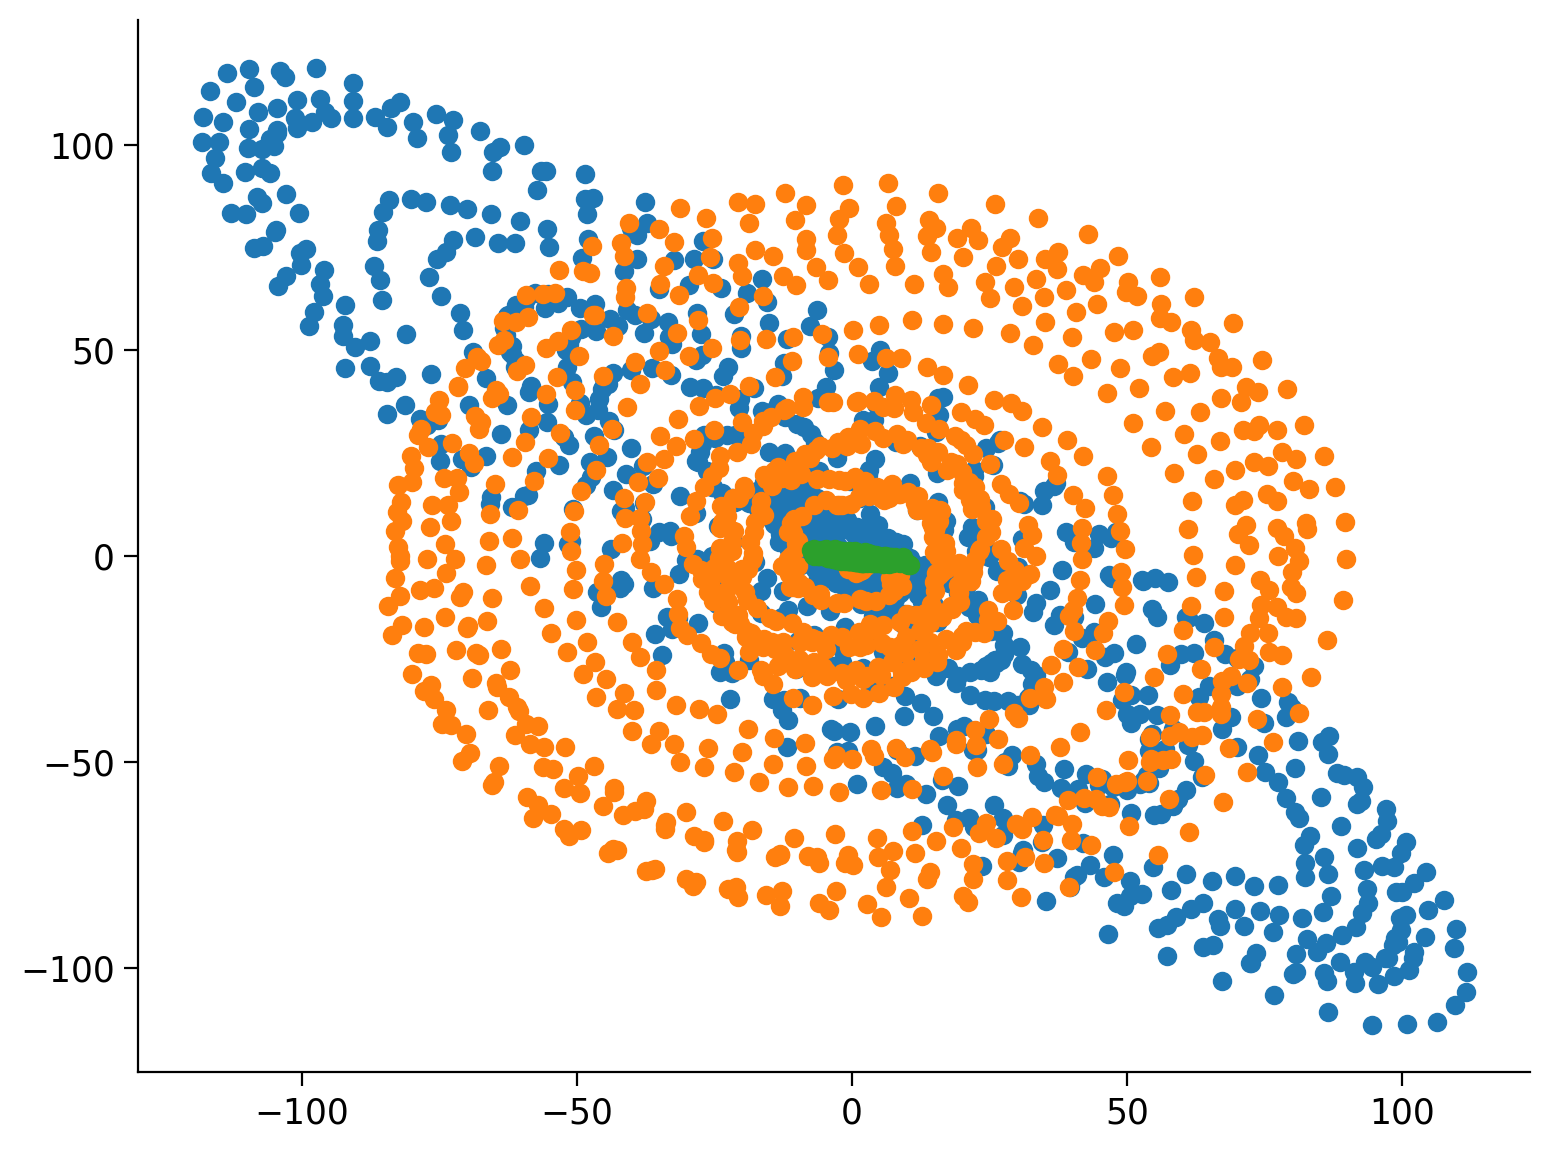

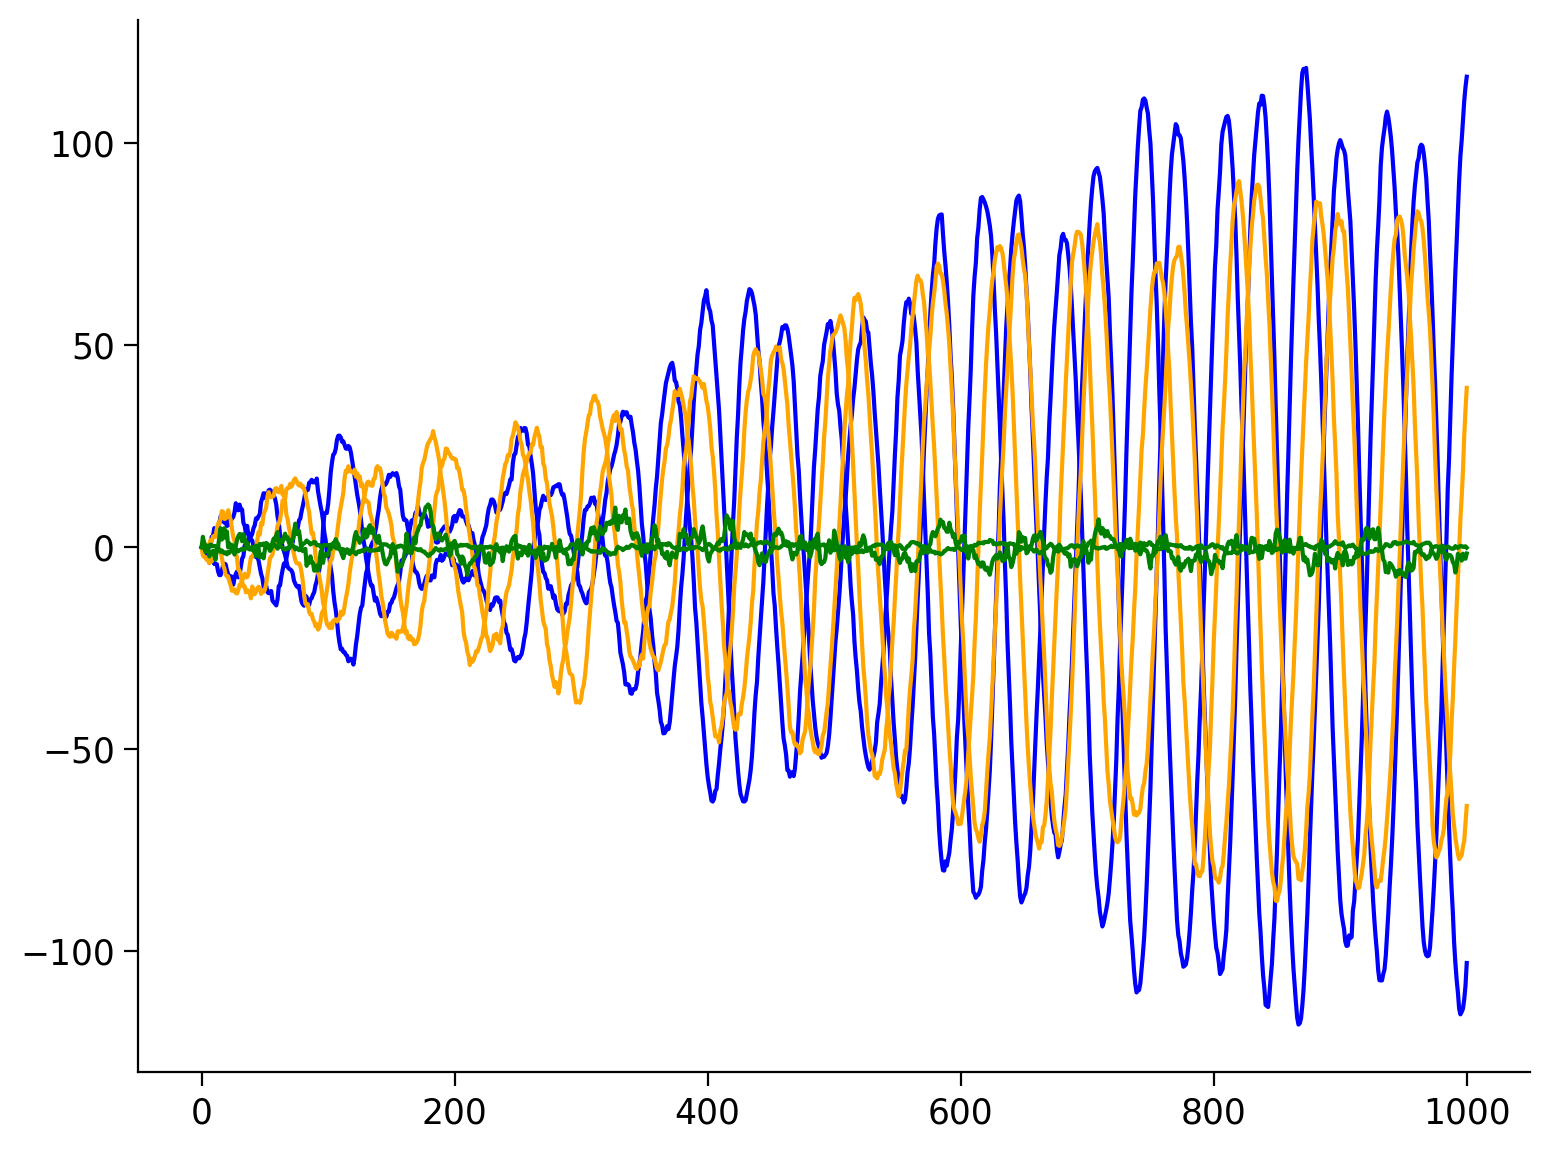

In [22]:
plt.plot(*trajectory_oval.T, 'o')
plt.plot(*trajectory_circle.T, 'o')
plt.plot(*trajectory_walk.T, 'o')
plt.show()
plt.plot(trajectory_oval, color ='blue')
plt.plot(trajectory_circle, color ='orange')
plt.plot(trajectory_walk, color ='green')
plt.show()

Can you see how the spatial / geometric similarity of `R-Walk` and `Oval` are more similar, but the oscillations during the temporal sequence are shared between `Circle` and `Oval`? Let's run Dynamic Similarity Analysis on these temporal sequences and see what scores are returned.

We calcularted `trajectory_oval` and `trajectory_circle` above, so let's plug these into the `DSA` function imported earlier (in the helper function cell) and see what the similarity score is.

In [12]:
# Define the DSA computation class
dsa = DSA(X=trajectory_oval, Y=trajectory_circle, n_delays=1)

# Call the fit method and save the result
similarities_oval_circle = dsa.fit_score()

print(f"DSA similarity between Oval and Circle: {similarities_oval_circle:.4f}")

DSA similarity between Oval and Circle: 0.0011


## Multi-way Comparison

We're now going to run DSA on our three trajectories and fit the model, returning the scores which we can investigate by plotting a confusion matrix with a heatmap to show the DSA scores.

In [13]:
n_delays = 1
delay_interval = 1

models = [trajectory_circle, trajectory_oval, trajectory_walk]
dsa = DSA(models, n_delays=n_delays, delay_interval=delay_interval)
similarities = dsa.fit_score()

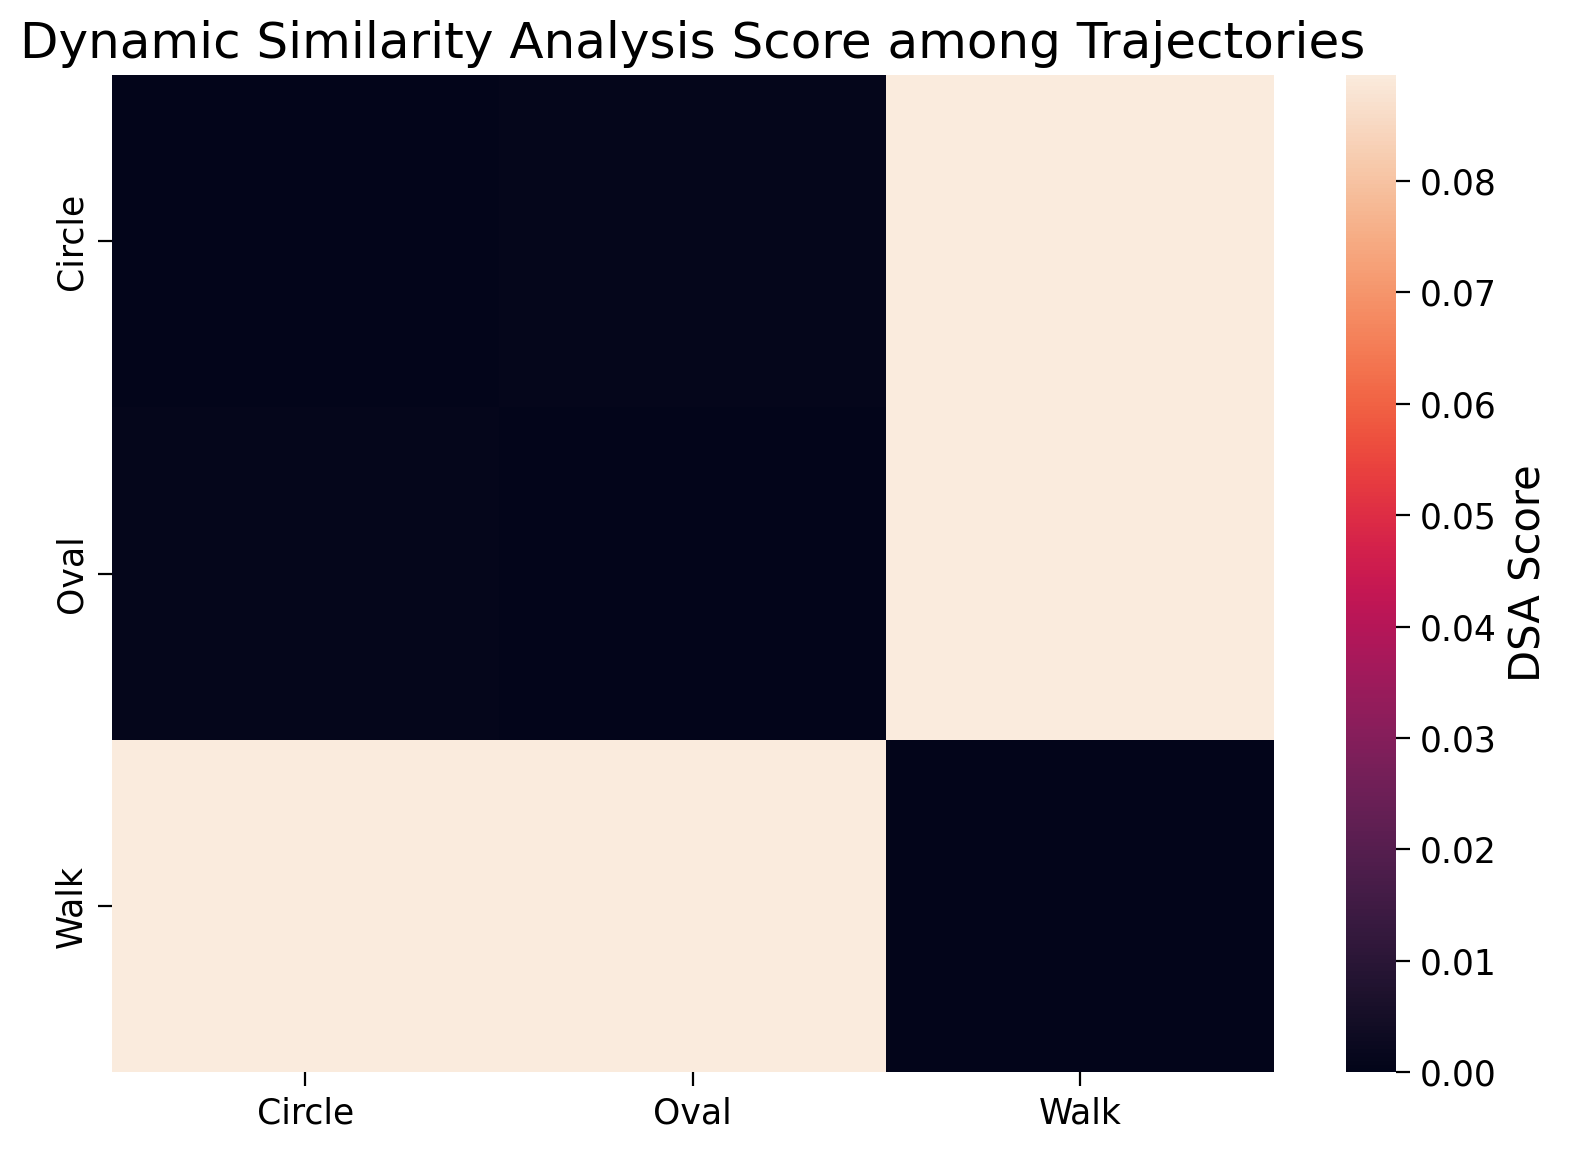

In [14]:
labels = ['Circle', 'Oval', 'Walk']
data = np.random.rand(len(labels), len(labels))
ax = sns.heatmap(similarities, xticklabels=labels, yticklabels=labels)
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('DSA Score');
plt.title("Dynamic Similarity Analysis Score among Trajectories");

This heatmap across the three model comparisons shows that the DSA scores between (`Walk` and `Circle`) and (`Walk` and `Oval`) to be (relatively) high, while the comparison between (`Circle` and `Oval`) is very low. Please note that this confusion matrix is symmetrical, meaning that the analysis between `trajectory_A` and `trajectory_B` returns the same dynamic similarity score as `trajectory_B` and `trajectory_A`. This is a common feature we have also seen in comparison metrics in standard RSA. One thing to note in the calculation of DSA is that comparisons among identical trajectories is `0`. This is unlike in RSA where we expect the correlation among the same stimuli to be `1.0`. This is why we see black squares along the diagonal.

Let's put our thinking caps on for a moment: This isn't really the result we would have expected, right? What do you think might be going on here? Have a look back at the *hyperparameters* and try to make an educated guess!

## DSA Hyperparameters (`n_delays` and `delay_interval`)

We'll now give you a hint as to why the setting of these hyperparameters is important when considering dynamic similarity analysis. The oscillators we have placed in the trajectories of `Circle` and `Oval` are not immediately apparent if you study only the previous time step for each element. It's only when considering the recurring pattern across a few different temporal delays and at what delay interval you want those to be, that we would expect to be able to detect recurring oscillations that provide us with the information we need to conclude that `Oval` and `Circle` are actually *dynamically* similar.

You should change the values below to be more sensible hyperparameter settings and re-run the model and plot the new confusion matrix. Try using `n_delays` equal to `20` and `delay_interval` equal to `10`. Don't forget to define `models` (see above example if you get stuck).

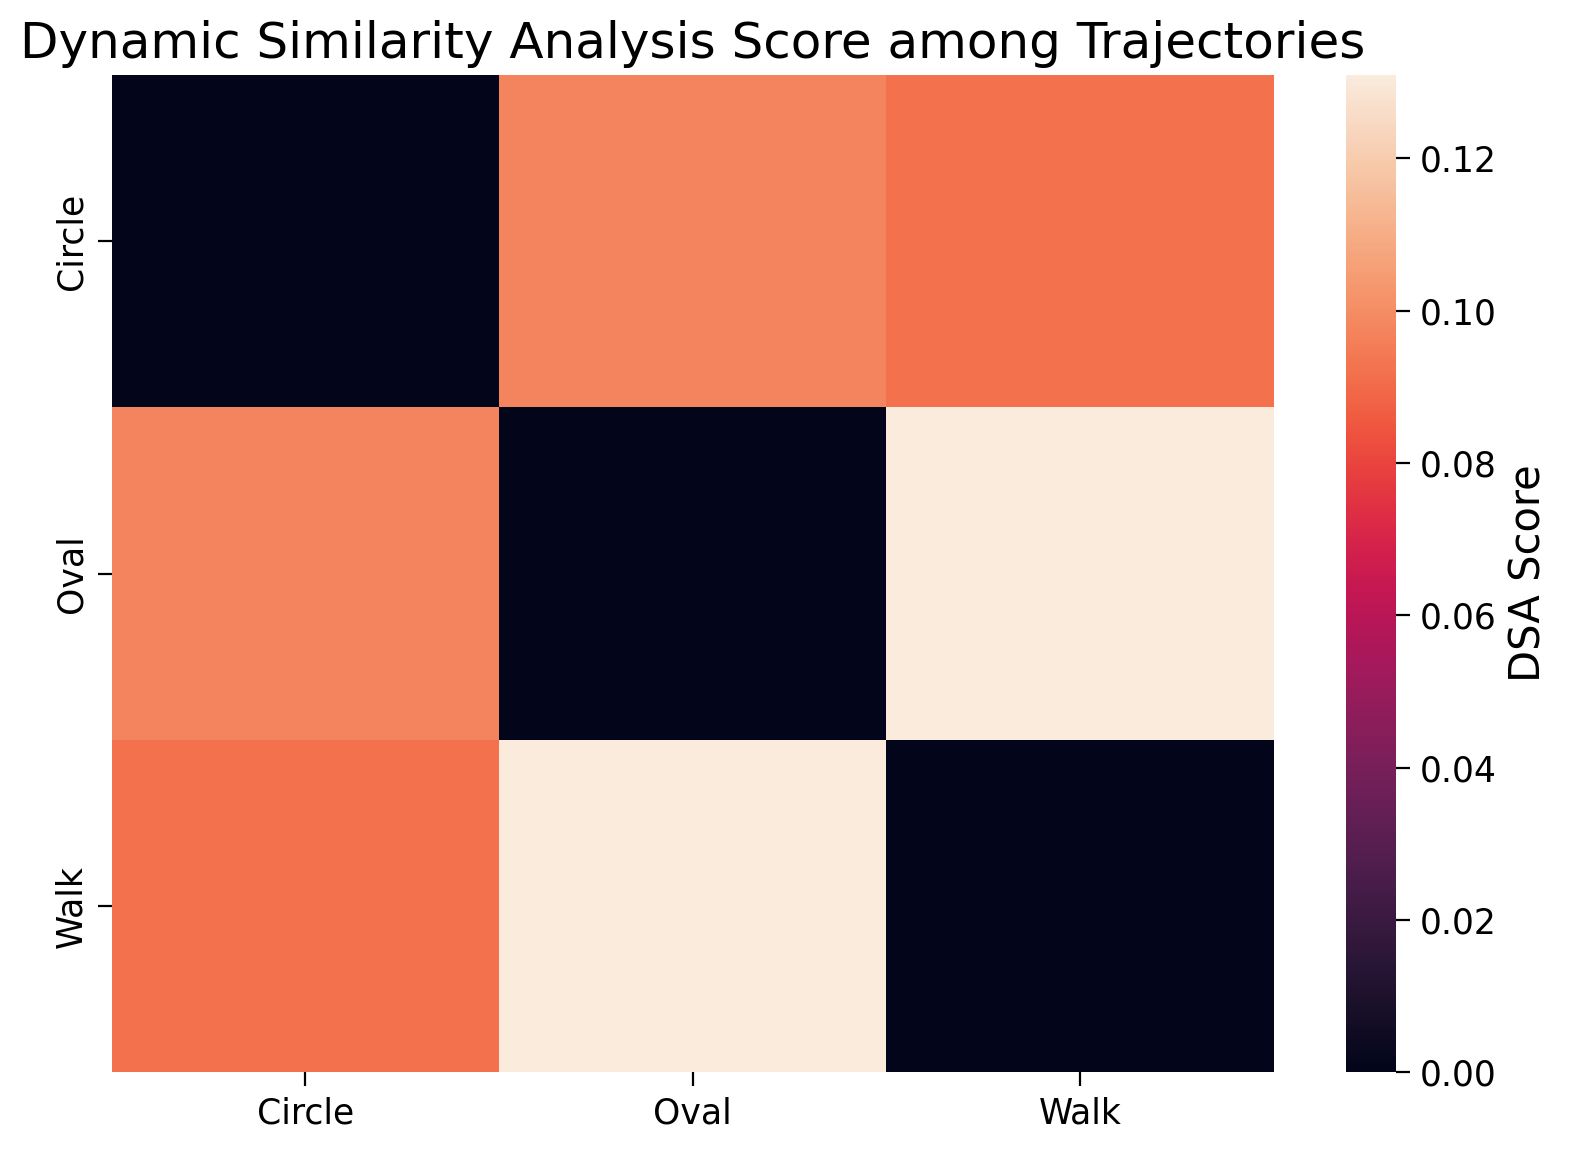

In [24]:
#################################################
## TODO for students: fill in the missing parts ##
# raise NotImplementedError("Student exercise")
#################################################

n_delays = 20
delay_interval = 10

models = [trajectory_circle, trajectory_oval, trajectory_walk]
dsa = DSA(models, n_delays=n_delays, delay_interval=delay_interval)
similarities = dsa.fit_score()

labels = ['Circle', 'Oval', 'Walk']
ax = sns.heatmap(similarities, xticklabels=labels, yticklabels=labels)
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('DSA Score');
plt.title("Dynamic Similarity Analysis Score among Trajectories");

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/solutions/W1D3_Tutorial5_Solution_0467919d.py)

*Example output:*

<img alt='Solution hint' align='left' width=784.0 height=575.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/static/W1D3_Tutorial5_Solution_0467919d_0.png>



What do you see now? We now see a much more sensible result. The DSA scores have now correctly identified that `Oval` and `Circle` are very dynamically similar! They have the highest color score according to the colorbar on the side. As is always good practice in science, let's have a look inside the `similarities` variable to look at the exact values and confirm what we see in the figure above.

In [25]:
similarities

array([[0.        , 0.09728236, 0.09160592],
       [0.09728236, 0.        , 0.1309762 ],
       [0.09160592, 0.1309762 , 0.        ]])

## Comparison with RSA

At the start of this exercise, we saw three different trajectories and pointed out that the random walk and oval shapes were most similar from a geometric perspective, both ellipse-like but not similar in their dynamic similarity. To better show the difference between DSA and RSA, we encourage you to run another comparison where we consider each time step to be a pair in the X,Y space and we will look at the the similarity between of `Oval` with both `Circle` and `Walk`. If our understanding is correct, then RSA should indicate a higher geometric similarity between (`Oval` and `Walk`) than with (`Oval` and `Circle`).

---
# (Bonus) Representational Geometry of Recurrent Models

Transformations of representations can occur across space and time, e.g., layers of a neural network and steps of recurrent computation. We've looked at the temporal dimension today and earlier today in the other tutorials we looked mainly at spatial representations.

Just as the layers in a feedforward DNN can change the representational geometry to perform a task, steps in a recurrent network can reuse the same layer to reach the same computational depth.

In this section, we look at a very simple recurrent network with only 2650 trainable parameters.

Here is a diagram of this network:

![Recurrent convolutional neural network](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/static/rcnn_tutorial.png?raw=true)

In [26]:
# @title Grab a recurrent model

args = build_args()
train_loader, test_loader = fetch_dataloaders(args)
path = "recurrent_model.pth"
model_recurrent = torch.load(path, map_location=args.device, weights_only=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 56.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.63MB/s]


<br>We can first look at the computational steps in this network. As we see below, the `conv2` operation is repeated for 5 times.

In [27]:
train_nodes, _ = get_graph_node_names(model_recurrent)
print('The computational steps in the network are: \n', train_nodes)

The computational steps in the network are: 
 ['input', 'conv1', 'conv2', 'add', 'relu', 'conv2_1', 'add_1', 'relu_1', 'conv2_2', 'add_2', 'relu_2', 'conv2_3', 'add_3', 'relu_3', 'conv2_4', 'add_4', 'relu_4', 'readout.dropout', 'readout.avgpool', 'readout.flatten', 'readout.linear', 'softmax']


Plotting the RDMs after each application of the `conv2` operation shows the same progressive emergence of the blockwise structure around the diagonal, mediating the correct classification in this task.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


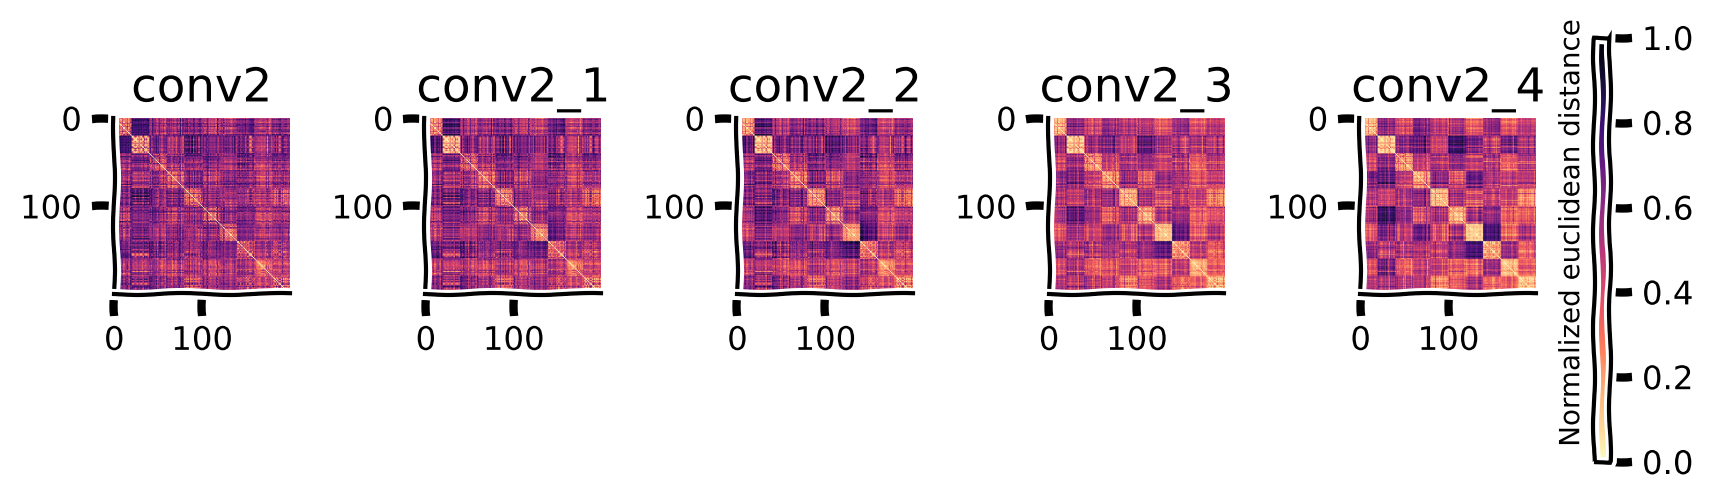

In [28]:
imgs, labels = sample_images(test_loader, n=20)
return_layers = ['conv2', 'conv2_1', 'conv2_2', 'conv2_3', 'conv2_4']
model_features = extract_features(model_recurrent, imgs.to(device), return_layers)

rdms, rdms_dict = calc_rdms(model_features)
plot_rdms(rdms_dict)

We can also look at how the different dimensionality reduction techniques capture the dynamics of changing geometry.

In [ ]:
return_layers = ['conv2', 'conv2_1', 'conv2_2', 'conv2_3', 'conv2_4']

imgs, labels = sample_images(test_loader, n=50) #grab 500 samples from the test set
model_features = extract_features(model_recurrent, imgs.to(device), return_layers)

plot_dim_reduction(model_features, labels, transformer_funcs =['PCA', 'MDS', 't-SNE'])

## Representational geometry paths for recurrent models

We can look at the model's recurrent computational steps as a path in the representational geometry space.

In [ ]:
imgs, labels = sample_images(test_loader, n=50) #grab 500 samples from the test set
model_features_recurrent = extract_features(model_recurrent, imgs.to(device), return_layers='all')

#rdms, rdms_dict = calc_rdms(model_features)
features = {'recurrent model': model_features_recurrent}
model_colors = {'recurrent model': 'y'}

rep_path(features, model_colors, labels)

We can also look at the paths taken by the feedforward and the recurrent models and compare them.

If you recall back to Tutorial 2, we compared a standard feedward model's representations. We can extend our analysis of the analysis of the recurrent model's representations by making a side-by-side comparison. We can also look at the paths taken by the feedforward and the recurrent models and compare them. What we see above in the case of the recurrent model is the fast-shifting path through the geometric space from inputs to labels. This illustration serves to show that models take many different paths and can have very diverse underlying mechanisms but still arrive at a superficially similar output at the end of training.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_recurrent_models")

# The Big Picture

Today, you've looked at what it means to measure representations from different systems. These systems can be of the same type (multiple brain systems, multiple artificial models) as well as with representations between these systems. In NeuroAI, we're especially interested in such comparisons, comparing representational systems in deep learning networks, for instance, to brain recordings recorded while those biological systems experienced / perceived the same set of stimuli. Comparisons can be geometric / spatial or they can be temporal. Today, we looked at Dynamic Similarity Analysis, a method used to be able to capture the dependencies among trajectories, not just capturing the similarity of the full temporal sequence upon completion of the temporal sequence. It's often important to take into account multiple dimensions of representational similarity. A combination of tools is definitely required in the NeuroAI researcher's toolkit. We hope you have many chances to use these tools in your future work as NeuroAI researchers.